## k-Means
Clustering is a fundamental task in unsupervised learning, where the goal is to discover _meaningful groupings_ in the data. Unlike supervised learning, there is no target to learn — the algorithm must infer structure based solely on the features of the data.

One of the most widely used clustering algorithms is k-means, which aims to partition a dataset into $r$ clusters such that points within each cluster are close to each other in feature space. Originally, the number of clusters was $k$, hence k-means, but in the notation of this course, $r$ is the number of low-dimensional representations. Despite k-means being a very simple method, it often reveals interpretable structure and serves as a useful baseline in exploratory data analysis.

## Motivation
```{figure} /images/clustering/deckOfCards.jpg
---
height: 300px
name: Deck of Cards 
align: center
---
A deck of cards can be clustered into various forms of valid clusterings.
```
To understand the nature of clustering, consider a simple dataset: a **standard deck of 52 playing cards**. Each card can be described using features like:

- **Suit** (Hearts, Diamonds, Clubs, Spades)  
- **Rank** (2 through 10, Jack, Queen, King, Ace)  
- **Color** (Red or Black)

Now imagine you're asked to cluster this dataset into groups. What are some reasonable ways to group the cards?

- You could group them by **suit** — forming four clusters (Hearts, Diamonds, Clubs, Spades).
- You could group them by **rank** — so that all Aces are together, all 2s are together, and so on.
- You could group by **color** — two clusters: red cards and black cards.
- You could even define groups based on custom similarity, such as grouping all face cards together or separating prime-numbered cards.

Each of these groupings is **valid** depending on what we consider similar or meaningful. This illustrates a core aspect in clustering: it has no universally correct answer. The grouping that we want depends on our assumptions about the ground truth clustering.    

Motivating examples in clustering often look like the blobs below:

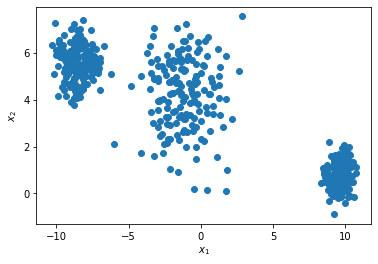

In [1]:
from sklearn import datasets
import matplotlib.pyplot as plt
epsilon=0.3
D, labels = datasets.make_blobs(n_samples=500,centers=3, cluster_std=[epsilon + 0.5, epsilon + 1.25, epsilon + 0.25],random_state=7)
plt.scatter(D[:,0],D[:,1])
plt.xlabel("$x_1$")
plt.ylabel("$x_2$")
plt.show()

We can visually see that there are three clusters -- three point clouds that are visibly separated from each other. However, if our data has more than two dimensions, then it becomes difficult up to impossible to detect the clusters visually. In these cases, k-means is supposed to give us the clusters, assuming the clusters are as nicely shaped as in this two-dimensional blobs example. 

## Formal Problem Definition
The k-means algorithm makes specific assumptions about the clustering structure:

1. Data points are vectors in Euclidean space (i.e., numerical features) and their distance is measured by Euclidean distance,
2. Every data point belongs to exactly one cluster,
3. Points within one cluster are similar

We denote our clustering as a series of indices-sets $\mathcal{C}_1,\ldots,\mathcal{C}_r$, where $\mathcal{C}_s\subseteq \{1,\ldots,n\}$ indicates the indices of our $n$ data points that belong to cluster $s$. The second assumption is then mathematically described by $\mathcal{C}_1,\ldots,\mathcal{C}_r$ forming a partition of $\{1,\ldots,n\}$, that is
$$\{\mathcal{C}_s\cap\mathcal{C}_t=\emptyset,\  \mathcal{C}_1\cup\ldots\cup\mathcal{C}_r\}=\{1,\ldots, n\}.$$
We denote the set of all partitions from $\{1,\ldots,n\}$ with $\mathcal{P}_n$.      

Point 3 states that points within a cluster are similar. We can express this assumption mathematically by stating that points within a cluster have a small (squared) Euclidean distance in average: 
   $$ \frac{1}{|\mathcal{C}_s|}\sum_{i,j\in\mathcal{C}_s}\|D_{i\cdot}-D_{j\cdot}\|^2$$
This allows us to formalize our k-means clustering task as follows:

`````{admonition} Task (k-means)
:class: tip
**Given** a data matrix $D\in\mathbb{R}^{n\times d}$ and the number of clusters $r$.     
**Find** clusters $\{\mathcal{C}_1,\ldots,\mathcal{C}_r\}\in\mathcal{P}_n$ which create a partition of $\{1,\ldots,n\}$, minimizing the distance between points within clusters (**within cluster scatter**):
:::{math}
:label: eq:k-means
\begin{align}
\min_{\{\mathcal{C}_1,\ldots,\mathcal{C}_r\}\in\mathcal{P}_n} &\ \sum_{s=1}^r\frac{1}{|\mathcal{C}_s|}\sum_{j,i\in\mathcal{C}_s}\|D_{j\cdot}-D_{i\cdot}\|^2 \label{eq:k-means}
\end{align}
:::
**Return** the clusters $\mathcal{C}_1,\ldots,\mathcal{C}_r$ 
`````

## Optimization
The objective in the k-means task is not easy to optimize. In particular the discrete nature of assigning points to clusters is problematic, since we can't apply our numerical optimization schemes to a discrete optimization task. As so often with nasty objectives, it is also here possible to transform this objective into a form that gives a clearer idea on how to optimize it.

The theorem below shows that minimizing the within cluster scatter is equivalent to minimizing the distance of points to their centroid.
````{prf:theorem}
The $k$- means objective in Eq. {eq}`eq:k-means` is equivalent to
:::{math}
:label: eq:k-means_centr
\begin{align*}
\min_{\mathcal{C}_1,\ldots,\mathcal{C}_r}&\ \sum_{s=1}^r\sum_{i\in\mathcal{C}_s} \lVert D_{i\cdot}-X_{\cdot s}^\top\rVert^2
\text{s.t. }X_{\cdot s}=\frac{1}{|\mathcal{C}_s|}\sum_{i\in\mathcal{C}_s}D_{i\cdot}^\top,\ \{\mathcal{C}_1,\ldots,\mathcal{C}_r\}\in\mathcal{P}_n
\end{align*}
:::
````
````{toggle}
```{prf:proof}
The objective function in Eq. {eq}`eq:k-means` returning the average distance of points within one cluster can be transformed as follows: 
\begin{align}
   &\sum_{s=1}^r\frac{1}{|\mathcal{C}_s|}\sum_{j\in\mathcal{C}_s}{\color{magenta}\sum_{i\in\mathcal{C}_s}}\lVert {\color{magenta}D_{i\cdot}}-D_{j\cdot}\rVert^2\\ 
    &= \sum_{s=1}^r\frac{1}{|\mathcal{C}_s|}\sum_{j\in\mathcal{C}_s}{\color{magenta}\sum_{i\in\mathcal{C}_s}}\left(
    {\color{magenta}\lVert D_{i\cdot}\rVert^2} - 2{\color{magenta}D_{i\cdot}}D_{j\cdot}^\top +
    \lVert D_{j\cdot} \rVert^2\right)\quad\text{(binomial formula)}\\
    &= \sum_{s=1}^r\left(\frac{1}{|\mathcal{C}_s|}\sum_{j\in\mathcal{C}_s}{\color{magenta}\sum_{i\in\mathcal{C}_s}}
    {\color{magenta}\lVert D_{i\cdot}\rVert^2}
    - \frac{1}{|\mathcal{C}_s|}\sum_{j\in\mathcal{C}_s}{\color{magenta}\sum_{i\in\mathcal{C}_s}}2{\color{magenta}D_{i\cdot}}D_{j\cdot}^\top +
    \frac{1}{|\mathcal{C}_s|}\sum_{j\in\mathcal{C}_s}{\color{magenta}\sum_{i\in\mathcal{C}_s}}\lVert D_{j\cdot} \rVert^2\right)\\
    &= \sum_{s=1}^r\left({\color{magenta}\sum_{i\in\mathcal{C}_s}}
    {\color{magenta}\lVert D_{i\cdot}\rVert^2}
    -2{\color{magenta}\sum_{i\in\mathcal{C}_s} D_{i\cdot}} \frac{1}{|\mathcal{C}_s|}\sum_{j\in\mathcal{C}_s}D_{j\cdot}^\top +
    \sum_{j\in\mathcal{C}_s}\lVert D_{j\cdot} \rVert^2\right)\\
    &=\sum_{s=1}^r\left(2{\color{magenta}\sum_{i\in\mathcal{C}_s}\lVert D_{i\cdot}\rVert^2}-2{\color{magenta}\sum_{i\in\mathcal{C}_s} D_{i\cdot}} \frac{1}{|\mathcal{C}_s|}\sum_{j\in\mathcal{C}_s}D_{j\cdot}^\top\right) 
\end{align}
This transformation introduces the centroid to the objective, it is given by the term on the right:
 \begin{align}
    Dist(\mathcal{C}_1,\ldots,\mathcal{C}_r)
    &=2\sum_{s=1}^r\Biggl(\sum_{i\in\mathcal{C}_s}\lVert D_{i\cdot}\rVert^2-\sum_{i\in\mathcal{C}_s} D_{i\cdot} \underbrace{\frac{1}{|\mathcal{C}_s|}\sum_{j\in\mathcal{C}_s}D_{j\cdot}^\top}_{X_{\cdot s}}\Biggr)
\end{align}
$X_{\cdot s}$ is the centroid (the arithmetic mean position) of all points assigned to cluster $\mathcal{C}_s$.
We rearrange the terms now, such that we can again apply the binomial formula for norms, where the norm is used to measure  the distance of a point in a cluster to the corresponding centroid:
\begin{align}
        Dist(\mathcal{C}_1,\ldots,\mathcal{C}_r)
    &=2\sum_{s=1}^r\Biggl({\color{magenta}\sum_{i\in\mathcal{C}_s}\lVert D_{i\cdot}\rVert^2}-\underbrace{\underbrace{{\color{magenta}\sum_{i\in\mathcal{C}_s} D_{i\cdot}}}_{\lvert\mathcal{C}_s\rvert X_{\cdot s}^\top} \underbrace{\frac{1}{|\mathcal{C}_s|}\sum_{j\in\mathcal{C}_s}D_{j\cdot}^\top}_{X_{\cdot s}}}_{{\color{magenta}\sum_{i\in\mathcal{C}_s}}\lVert X_{\cdot s}\rVert^2}\Biggr)\\
    &=2\sum_{s=1}^r{\color{magenta}\sum_{i\in\mathcal{C}_s}} \left({\color{magenta}\lVert D_{i\cdot}\rVert^2}- 2{\color{magenta}D_{i\cdot}}X_{\cdot s} +\lVert X_{\cdot s}\rVert^2\right)\\
    &=2\sum_{s=1}^r{\color{magenta}\sum_{i\in\mathcal{C}_s}} \lVert {\color{magenta}D_{i\cdot}}-X_{\cdot s}^\top\rVert^2
    &\text{(binomial formula)}
    \end{align}
The step from the first to the second equation follows by adding and subtracting the term $\sum_{i\in\mathcal{C}_s}\lVert X_{\cdot s}\rVert^2= \sum_{i\in\mathcal{C}_s} D_{i\cdot}X_{\cdot s}$.
```
````
$X_{\cdot s}$ is the **centroid** (the arithmetic mean position) of all points assigned to cluster $\mathcal{C}_s$.

Minimizing the distance of points to their centroids suggests an iterative two-step procedure, where we optimize subject to the centroids in one step and the clustering in the next step. As an example, let's consider the clustering of the three blobs data starting with some randomly sampled centroids (in magenta).

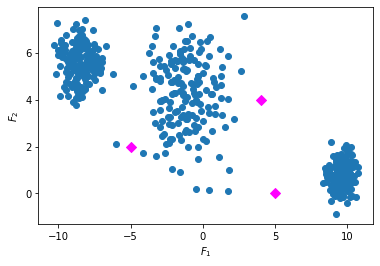

In [17]:
import numpy as np
plt.scatter(D[:,0],D[:,1])
X = np.array([[5,4,-5],[0,4,2]])# inital centroids
plt.scatter(X.T[:, 0], X.T[:, 1], c='magenta', s=50, marker = 'D') 
plt.xlabel("$F_1$")
plt.ylabel("$F_2$")
plt.show()

We assign every point to the cluster with the closest centroid.

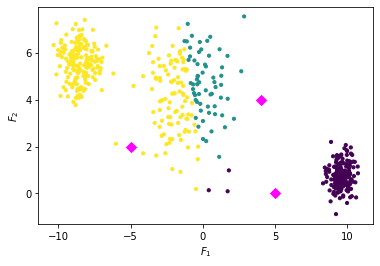

In [19]:
dist = np.sum(D**2,1).reshape(-1,1)  - 2* D@X + np.sum(X**2,0)
closest_centroid = np.argmin(dist,1)
plt.scatter(D[:, 0], D[:, 1], c=closest_centroid, s=10)
plt.scatter(X.T[:, 0], X.T[:, 1], c='magenta', s=50, marker = 'D')
plt.xlabel("$F_1$")
plt.ylabel("$F_2$")
plt.show()

Now the centroids are not actually centroids of all points in one cluster. Hence, we update the centroids.

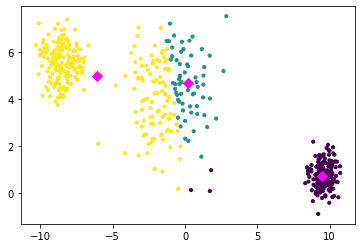

In [21]:
def getY(labels):
    Y = np.zeros((len(labels), max(labels)+1))
    for i in range(0, len(labels)):
        Y[i, labels[i]] = 1
    return Y
Y = getY(closest_centroid)
cluster_sizes = np.diag(Y.T@Y).copy()
cluster_sizes[cluster_sizes==0]=1
X = D.T@Y/cluster_sizes
plt.scatter(D[:, 0], D[:, 1], c=closest_centroid, s=10)
plt.scatter(X.T[:, 0], X.T[:, 1], c='magenta', s=50, marker = 'D')
plt.show()

Now we can again decrease the objective function by assigning the points to their closest centroid. We repeat the steps of assigning the points to their closest centroid and recomputing the centroids until the function value doesn't decrease anymore. This is known as **the** k-means algorithm. We show in the following video the steps until convergence for our example. 

In [29]:
from JSAnimation import IPython_display
from matplotlib import animation
from IPython.display import HTML
def animate(i):
    global X,D,Y
    ax.cla()
    if i==0: #initialize
        ax.scatter(D[:, 0], D[:, 1], s=10)
        ax.scatter(X.T[:, 0], X.T[:, 1], c='magenta', s=50, marker = 'D')  
    elif i%2==1: # update cluster assignments
        dist = np.sum(D**2,1).reshape(-1,1)  - 2* D@X + np.sum(X**2,0)
        closest_centroid = np.argmin(dist,1)
        Y = getY(closest_centroid)
        ax.scatter(D[:, 0], D[:, 1], c=closest_centroid, s=10)
        ax.scatter(X.T[:, 0], X.T[:, 1], c='magenta', s=50, marker = 'D')
    else: # update centroids
        _,closest_centroid = np.nonzero(Y)
        ax.scatter(D[:, 0], D[:, 1], c=closest_centroid, s=10)
        cluster_sizes = np.diag(Y.T@Y).copy()
        cluster_sizes[cluster_sizes==0]=1
        X = D.T@Y/cluster_sizes
        ax.scatter(X.T[:, 0], X.T[:, 1], c='magenta', s=50, marker = 'D')
    return
fig = plt.figure()
ax = plt.axes()
X = np.array([[5,4,-5],[0,4,2]])# inital centroids
Y=0
anim = animation.FuncAnimation(fig, animate, frames=9, interval=200, blit=False)
plt.close()
HTML(anim.to_jshtml())

This two step procedure has been proposed in **1957** by **Stuart Lloyd**, an engineer at Bell Labs, as a method for pulse-code modulation in signal processing. Interestingly, his work wasn’t widely known until it was published in a technical report in **1982**, and by then the algorithm had already been rediscovered multiple times under different names in various fields. In the context of clustering, it became known as the standard way to solve the k-means problem. The algorithm below details the procedure.

```{prf:algorithm} k-means (a.k.a. Lloyds algorithm)

**Input**: $D, r$
1. $X\gets$ `initCentroids`$(D, r)$ (centroid initialization)
2. **while** not converged
    1. **for** $s\in\{1,\ldots,r\}$ (cluster assignment)
        1. $\displaystyle\mathcal{C}_{s} \gets \left\{i\middle\vert s =\argmin_{1\leq t\leq r}\left\{\|X_{\cdot t}-D_{i\cdot}^\top\|^2\right\},1\leq i\leq n\right\}$
    2. **for** $s\in\{1,\ldots,r\}$ (centroid computation)
        1.  $\displaystyle X_{\cdot s}\gets \frac{1}{|\mathcal{C}_s|}\sum_{i\in\mathcal{C}_s}D_{i\cdot}^\top$     
3. **return** $\{\mathcal{C}_1,\ldots,\mathcal{C}_r\}$
```